# Fraud Analytics: Data Preparation & Modeling

## Data Preprocessing

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

### Load the dataset

In [2]:
df = pd.read_csv("financial_data_log.csv")

# Display first few rows
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,615,TRANSFER,56510.50,C956959892,56510.50,0.00,C582952352,0.0,0.00,1,0
1,714,TRANSFER,10000000.00,C131412689,10390763.24,390763.24,C1846567377,0.0,0.00,1,0
2,324,TRANSFER,21580.37,C765450059,21580.37,0.00,C125935569,0.0,0.00,1,0
3,668,CASH_OUT,1576531.53,C2000069930,1576531.53,0.00,C1345448010,0.0,1576531.53,1,0
4,499,TRANSFER,488243.65,C2117568077,488243.65,0.00,C1238599279,0.0,0.00,1,0


### Check for Missing Values

In [3]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


### Check for duplicate records

In [4]:
duplicates = df.duplicated().sum()
print(f"Duplicate Records: {duplicates}")

Duplicate Records: 3


In [5]:
# Remove duplicate records
df = df.drop_duplicates()

print(f"Duplicate Records: {df.duplicated().sum()}")


Duplicate Records: 0


### Separate features (X) and target (y)

In [6]:
X = df.drop(columns=["isFraud"])  # All columns except fraud label
y = df["isFraud"]  # Fraud label (0 = Not Fraud, 1 = Fraud)

print(f"Feature Set Shape: {X.shape}")
print(f"Target Set Shape: {y.shape}")

Feature Set Shape: (19997, 10)
Target Set Shape: (19997,)


### Split into training (80%) and testing (20%) sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set Size: {X_train.shape}, Testing Set Size: {X_test.shape}")

Training Set Size: (15997, 10), Testing Set Size: (4000, 10)


## Exploratory Data Analysis (EDA)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Univariate & Bivariate Analysis

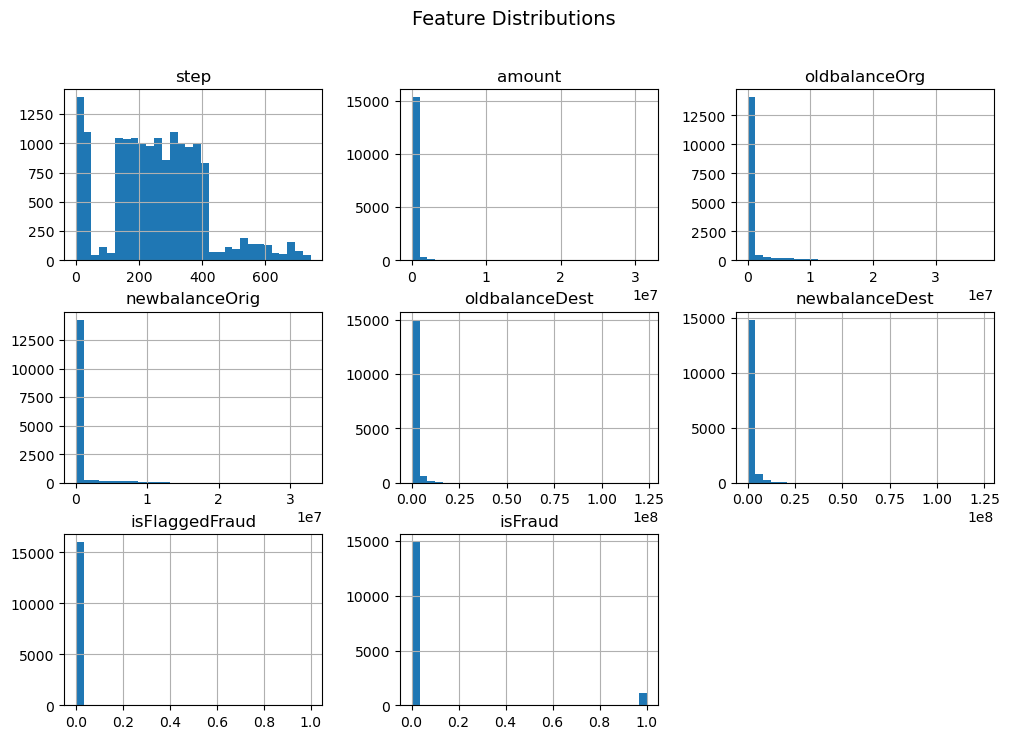

In [9]:
# Merge features with the target column
df_train = X_train.copy()  
df_train["isFraud"] = y_train

# Univariate Analysis - Histograms
df_train.hist(figsize=(12, 8), bins=30)
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

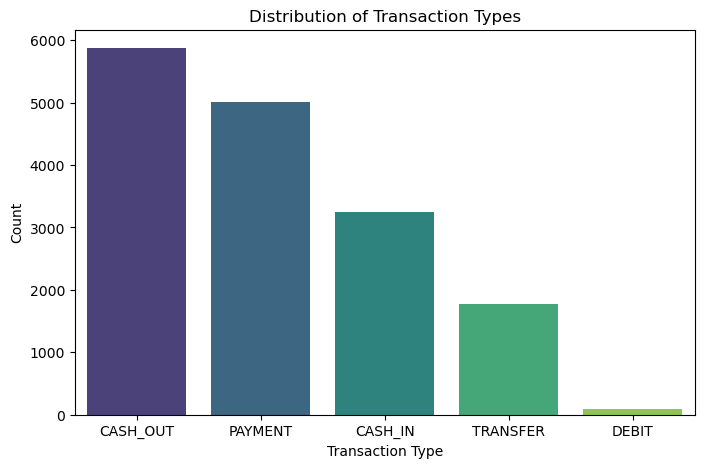

In [10]:
# Plot histogram for transaction types
plt.figure(figsize=(8, 5))
sns.countplot(data=df_train, x="type", palette="viridis")
plt.title("Distribution of Transaction Types")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

- The distribution of `amount` is highly right skewed, meaning most transactions are small but few are very large
- The distribution of `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, and `newbalanceDest` are also right skewed, thus many accounts have low balances, but some have extremely high balances.
- `isFlaggedFraud` and `isFraud` are extremely right skewed with the vast majority of transactions not being fraudulent.
- The distribution of `type` shows that cash out and payments are the most common transactions, while direct debits are pretty uncommon.

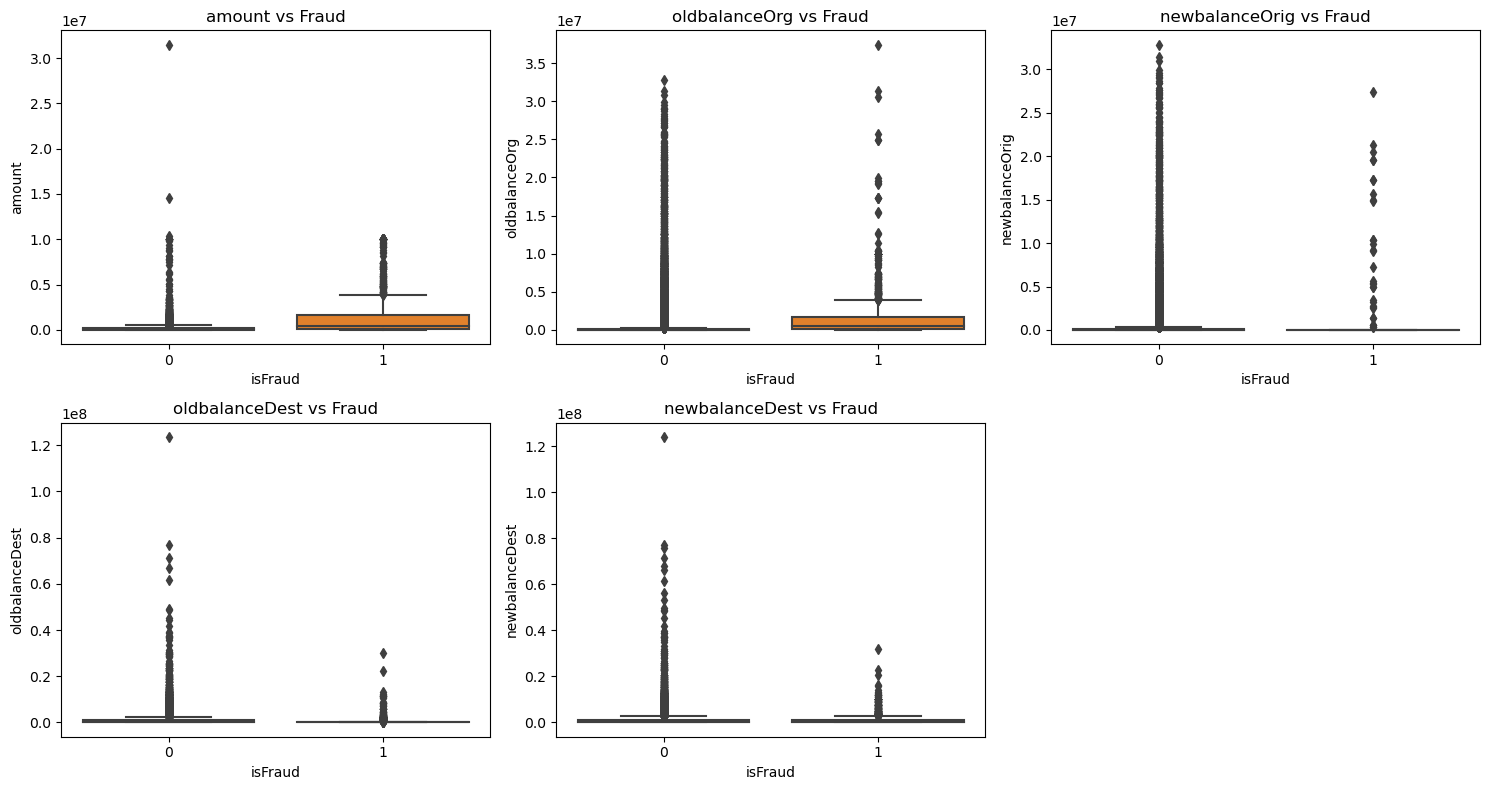

In [11]:
# Bivariate Analysis - Boxplots
plt.figure(figsize=(15, 8))
features = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df_train["isFraud"], y=df_train[feature])
    plt.title(f"{feature} vs Fraud")
plt.tight_layout()
plt.show()

- Fraudulent transactions have a much higher median amount compared to non-fraud.
- Fraud cases tend to start with higher balances.
- Fraud cases have a very high range of destination balances.

### Multivariate Analysis

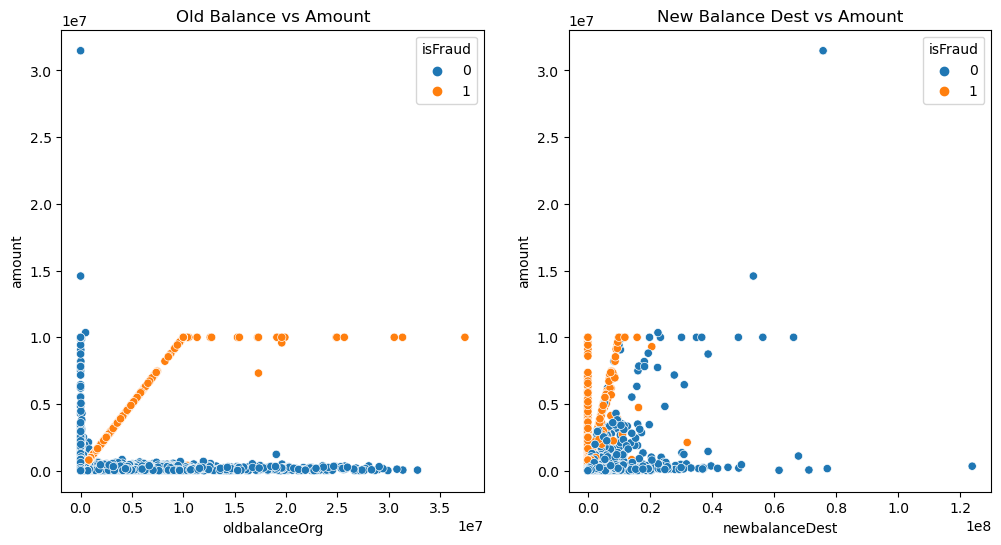

In [12]:
# Scatter Plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_train["oldbalanceOrg"], y=df_train["amount"], hue=df_train["isFraud"])
plt.title("Old Balance vs Amount")

plt.subplot(1, 2, 2)
sns.scatterplot(x=df_train["newbalanceDest"], y=df_train["amount"], hue=df_train["isFraud"])
plt.title("New Balance Dest vs Amount")

plt.show()

- It appears there is a positive relationship between the original balance of the originating account and the transaction amount, meaning higher balances correlate with higher transaction amounts.
- The relationship between the new balance of the destination account and the transaction amount also have a positive correlation, where higher transaction amounts result in higher new balances in the destination account.

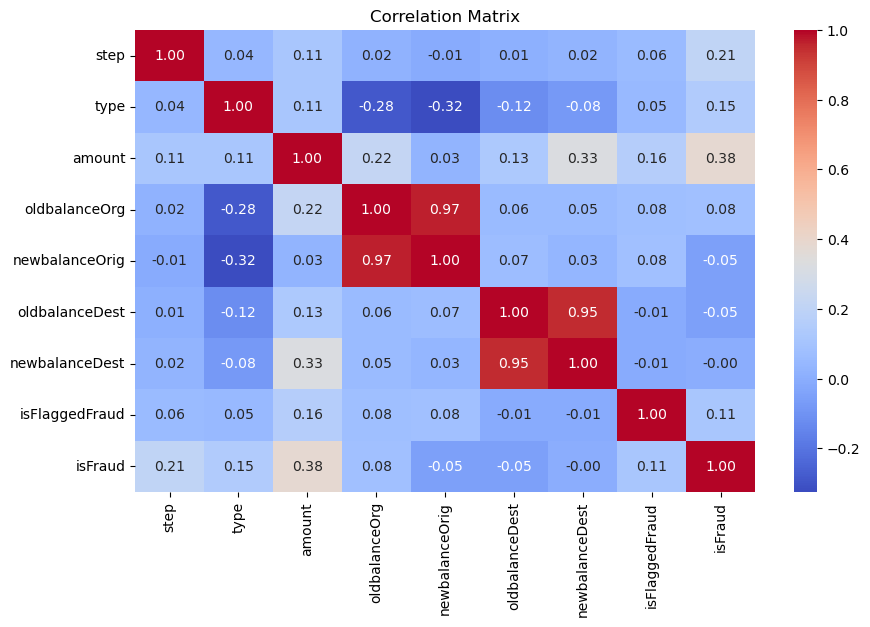

In [13]:
df_train_encoded = df_train.copy()
df_train_encoded['type'] = df_train_encoded['type'].astype('category').cat.codes

# Select only numeric columns
numeric_df = df_train_encoded.select_dtypes(include=[np.number])

# Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

- `oldbalanceOrg` and `newbalanceOrig` have a very high positive correlation (0.97), indicating they are strongly related.
- `oldbalanceDest` and `newbalanceDest` also have a very high positive correlation (0.95).
- `amount` has a positive correlation with `newbalanceDest` (0.33) and `isFraud` (0.38).
- `isFraud` has a positive correlation with `amount` and `isFlaggedFraud`.
- Most other correlations are relatively weak.

### Outlier Detection

In [14]:
outliers = df_train[df_train["amount"] > df_train["amount"].quantile(0.99)]
print(f"Top 1% highest transactions:\n{outliers[['amount', 'isFraud']].head()}")

Top 1% highest transactions:
            amount  isFraud
226    10000000.00        1
330    10000000.00        1
1209    9299230.13        1
11897  10000000.00        0
113     7469051.14        1


- Fraudulent transactions tend to involve extremely large amounts.
- Not all high-value transactions are fraudulent, but most in this subset are.

### Key Insights:
- Fraudulent transactions tend to involve **very high amounts**, as shown by the right-skewed distribution of amount, while most transactions remain small.
- Fraud cases often **start with higher balances**, and destination balances show a wide range.
- There is a **strong positive correlation** between `oldbalanceOrg` and `newbalanceOrig`* and between `oldbalanceDest` and `newbalanceDest`, suggesting that many transactions
     maintain balance consistency.
- High-value transactions are not always fraudulent, but most fraud cases involve large amounts, making **extreme transaction values an important red flag** for detection.

## Weight of Evidence (WOE)

### Binning method

In [15]:
def bin_variable(df, col, bins):
    labels = [f'Bin_{i}' for i in range(len(bins) - 1)]
    df[f'{col}_bin'] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    return df

### Calculate WOE and IV

In [16]:
def calculate_woe_iv(df, feature, target):
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.columns = ['Total', 'Fraud']
    grouped['Non_Fraud'] = grouped['Total'] - grouped['Fraud']
    
    # Avoid division by zero by replacing zeros with small numbers
    grouped['Fraud'] = grouped['Fraud'].replace(0, 0.5)
    grouped['Non_Fraud'] = grouped['Non_Fraud'].replace(0, 0.5)
    
    grouped['Fraud_Rate'] = grouped['Fraud'] / grouped['Fraud'].sum()
    grouped['Non_Fraud_Rate'] = grouped['Non_Fraud'] / grouped['Non_Fraud'].sum()
    grouped['WOE'] = np.log(grouped['Fraud_Rate'] / grouped['Non_Fraud_Rate'])
    
    # Information Value (IV)
    grouped['IV'] = (grouped['Fraud_Rate'] - grouped['Non_Fraud_Rate']) * grouped['WOE']
    iv_value = grouped['IV'].sum()

    return grouped[['WOE']], iv_value

### Apply function

In [17]:
# Apply WOE to 'amount'
bins = [0, 1000, 10000, 50000, 100000, df_train['amount'].max()]
df_train = bin_variable(df_train, 'amount', bins)
woe_table_amount, iv_amount = calculate_woe_iv(df_train, 'amount_bin', 'isFraud')

# Classify IV strength for 'amount'
if iv_amount > 0.3:
    strength_amount = "Strong"
elif iv_amount > 0.1:
    strength_amount = "Weak"
else:
    strength_amount = "Very Low"

# Apply WOE to 'type'
woe_table_type, iv_type = calculate_woe_iv(df_train, 'type', 'isFraud')

# Classify IV strength for 'type'
if iv_type > 0.3:
    strength_type = "Strong"
elif iv_type > 0.1:
    strength_type = "Weak"
else:
    strength_type = "Very Low"

In [18]:
# Print results
print("WOE for 'amount':\n", woe_table_amount)
print(f'IV Strength for "amount": {strength_amount}\n')

print("WOE for 'type':\n", woe_table_type)
print(f'IV Strength for "type": {strength_type}')

WOE for 'amount':
                  WOE
amount_bin          
Bin_0      -0.883557
Bin_1      -1.926232
Bin_2      -1.118618
Bin_3      -0.403292
Bin_4       0.591774
IV Strength for "amount": Strong

WOE for 'type':
                WOE
type              
CASH_IN  -6.194333
CASH_OUT  0.344587
DEBIT    -2.571987
PAYMENT  -6.624671
TRANSFER  1.799268
IV Strength for "type": Strong


In [19]:
# Check if the result correct
print(df_train.groupby('amount_bin')['isFraud'].mean())
print(df_train.groupby('type')['isFraud'].mean())

amount_bin
Bin_0    0.030120
Bin_1    0.010829
Bin_2    0.023962
Bin_3    0.047802
Bin_4    0.119557
Name: isFraud, dtype: float64
type
CASH_IN     0.000000
CASH_OUT    0.096000
DEBIT       0.000000
PAYMENT     0.000000
TRANSFER    0.312641
Name: isFraud, dtype: float64


Since `Bin_4` and `TRANSFER` have higher fraud rates, then our WOE values is *correct*

## Fraud Detection by Outlier

### IQR and Z-Score Function

In [20]:
# IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.0 * IQR
    upper_bound = Q3 + 1.0 * IQR
    return ((df[column] < lower_bound) | (df[column] > upper_bound)).astype(int)

# Z-score
def detect_outliers_zscore(df, column, threshold=2.5):
    mean = df[column].mean()
    std = df[column].std()
    return (np.abs((df[column] - mean) / std) > threshold).astype(int)

### Apply the Function

In [21]:
# Convert 'type' to its WOE values
woe_mapping = {
    "CASH_IN": -6.194,
    "CASH_OUT": 0.345,
    "DEBIT": -2.572,
    "PAYMENT": -6.625,
    "TRANSFER": 1.799
}
df_train["type_WOE"] = df_train["type"].map(woe_mapping)

In [22]:
# Apply IQR and Z-score
df_train["IQR_amount"] = detect_outliers_iqr(df_train, "amount")
df_train["IQR_oldbalanceOrg"] = detect_outliers_iqr(df_train, "oldbalanceOrg")
df_train["IQR_newbalanceOrig"] = detect_outliers_iqr(df_train, "newbalanceOrig")
df_train["IQR_type_WOE"] = detect_outliers_iqr(df_train, "type_WOE")

df_train["ZScore_amount"] = detect_outliers_zscore(df_train, "amount")
df_train["ZScore_oldbalanceOrg"] = detect_outliers_zscore(df_train, "oldbalanceOrg")
df_train["ZScore_newbalanceOrig"] = detect_outliers_zscore(df_train, "newbalanceOrig")

In [23]:
# Summarizing the results
df_train["Proportion"] = df_train[[ 
    "IQR_amount", "IQR_oldbalanceOrg", "IQR_newbalanceOrig", "IQR_type_WOE",
    "ZScore_amount", "ZScore_oldbalanceOrg", "ZScore_newbalanceOrig"
]].sum(axis=1) / 7  # Divide by total number of models

# Majority vote
df_train["Majority_Vote"] = (df_train["Proportion"] > 0.5).astype(int)

df_train[["IQR_amount", "IQR_oldbalanceOrg", "IQR_newbalanceOrig", "IQR_type_WOE",
          "ZScore_amount", "ZScore_oldbalanceOrg", "ZScore_newbalanceOrig",
          "Proportion", "Majority_Vote"]].head()

,IQR_amount,IQR_oldbalanceOrg,IQR_newbalanceOrig,IQR_type_WOE,ZScore_amount,ZScore_oldbalanceOrg,ZScore_newbalanceOrig,Proportion,Majority_Vote
5599,0,0,0,0,0,0,0,0.0,0
14173,0,0,0,0,0,0,0,0.0,0
12445,0,0,0,0,0,0,0,0.0,0
2737,0,0,0,0,0,0,0,0.0,0
18674,0,0,0,0,0,0,0,0.0,0


In [24]:
# Evaluation
from sklearn.metrics import classification_report

print(classification_report(df_train["isFraud"], df_train["Majority_Vote"]))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     14879
           1       0.12      0.06      0.08      1118

    accuracy                           0.91     15997
   macro avg       0.53      0.51      0.51     15997
weighted avg       0.88      0.91      0.89     15997



The **Precision** score shows that model is good at predicting non-fraud cases correctly, but it's wrong most of the time (many false positives) when predicting fraud cases. Based on **Recall**, out of all actual fraud cases, it only identifies **6%** as fraud.  

It's possible that the model is biased towards non-fraud due to **class imbalance**.  

## K-Means Clustering

### Data Scaling

In [26]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = df_train.copy()

features = ["amount", "oldbalanceOrg", "newbalanceOrig", "type_WOE"]
X = df[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Clustering

In [27]:
# Apply K-Means with 2 clusters (fraud and non-fraud)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Identify fraud cluster
fraud_cluster = df.groupby("cluster")["amount"].mean().idxmax()
df["fraud_pred"] = (df["cluster"] == fraud_cluster).astype(int)

### PCA

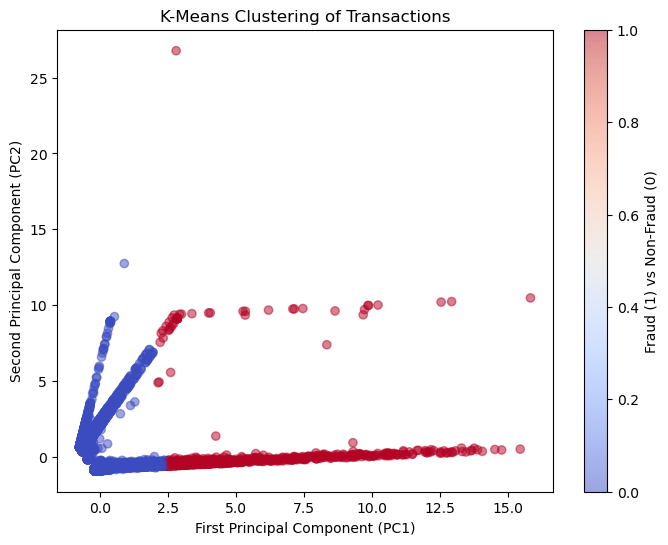

In [28]:
# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)
df["pca_1"] = X_pca[:, 0]  # First principal component
df["pca_2"] = X_pca[:, 1]  # Second principal component

# Scatter plot of clusters
plt.figure(figsize=(8, 6))
plt.scatter(df["pca_1"], df["pca_2"], c=df["fraud_pred"], cmap="coolwarm", alpha=0.5)
plt.xlabel("First Principal Component (PC1)")
plt.ylabel("Second Principal Component (PC2)")
plt.title("K-Means Clustering of Transactions")
plt.colorbar(label="Fraud (1) vs Non-Fraud (0)")
plt.show()

Since the non-fraud transactions (blue) are dense at the bottom left, it means most normal transactions have smaller amounts and they follow a similar pattern, so they are grouped closely together. On the other hand, Fraud transactions (red) are spread out, meaning they have different patterns and larger amounts. Some fraud points are far from the cluster, showing they behave very differently.